# Quantum Reservoir Computing

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [226]:
# DEFINE PARAMETERS
Num_spins = 5                                                          # number of spins
tlist = np.linspace(0, 100, 20000)                                     # time parameters
dt = tlist[1] - tlist[0]                                               # time incremental
delta_t = [0.1, 0.5, 1, 2, 4, 8, 12, 16]                               # time interval between two inputs
Num_trials = len(delta_t)


# DEFINE THE MODEL
h = 1                                                                  # transverse field strength
Js = 1
sx = sigmax()
sz = sigmaz()
si = qeye(2)
H = 0                                                                  # Initialize the Hamiltonian

for i in range(Num_spins):                                             # Build the interaction part
    for j in range(i+1, Num_spins):
        # Start with identities
        op_list = [si] * Num_spins
        # Place Pauli-x on the i-th spin 
        op_list[i] = sx
        # Place Pauli-x on the j-th spin
        op_list[j] = sx
        # Add interaction term with random coupling J
        J = np.random.uniform(-Js/2, Js/2)
        H += J * tensor(op_list)
        
        
for i in range(Num_spins):                                             # Build the transverse field part
    # Start with identities
    op_list = [si] * Num_spins
    # Place Pauli-z on the i-th spin
    op_list[i] = sz
    # Add transverse field term with transverse field strength h
    H += h * tensor(op_list)
    
U = qutip.propagator(H, dt)                                            # Build the propagator

# DEFINE THE OBSERVABLES
def observables(i, num_spins):
    # Create the list of operators for the tensor product
    # Start with identities
    operators = [si] * num_spins             
    # Replace the i-th operator with Pauli-z
    operators[i] = sz  

    # Take the tensor product of the list of operators
    M_i = tensor(operators)
    
    return M_i

# DEFINE MEASURES FUNCTIONS
def Hilbert_Schmidt_Distance(rho_1, rho_2):

    diff = rho_1 - rho_2
    distance = np.sqrt((diff.dag() * diff).tr())
    
    return distance

In [228]:
# START THE SIMULATION

distance_values = {i: [] for i in range(Num_trials)}                             # Define distance values storage for each delta t
expectation_values = {i: [] for i in range(Num_trials)}                          # Define observable expectation values storage
x_values = {i: [] for i in range(Num_trials)}                                    # Define RC variables storage

trial_count = 0
for t in delta_t:
    step_count = 0                                                               # Time-step counting
    expectation_values[trial_count] = {i: [] for i in range(Num_spins)}          # Define observable expectation values storage
    x_values[trial_count] = {i: [] for i in range(Num_spins)}                    # Define RC variables storage

    psi_current = tensor([basis(2, 0) for _ in range(Num_spins)])                # Define the initial state 1 and state 2 (for testing fading memory)
    psi_test = tensor([basis(2, 1) for _ in range(Num_spins)])
    rho_current = psi_current * psi_current.dag()
    rho_test = psi_test * psi_test.dag()
    for _ in tlist:
        if step_count % int(t / dt) == 0:                                          # Do the injection at t = delta_t = 10*dt
            s = np.random.uniform(0, 1)                                          # Encode the inputs   
            psi_inject = np.sqrt(1-s) * basis(2, 0) + np.sqrt(s) * basis(2, 1)   # Prepare the injection qubits
            rho_inject = psi_inject * psi_inject.dag()
            
            rho_reduced = rho_current.ptrace([1,2,3,4])                          # Partial trace current state over its spins that used for injection
            rho_current = tensor(rho_inject, rho_reduced)                        # Update the state by tensoring the injection qubits and the rest of its qubits
            rho_test_reduced = rho_test.ptrace([1,2,3,4])
            rho_test = tensor(rho_inject, rho_test_reduced)
            
            #Propagate the states 
            rho_current = U * rho_current * U.dag()
            rho_test = U * rho_test * U.dag()
            
            x_values[trial_count][0].append((observables(0, 5) * rho_current).tr())  # Calculate RC variables at current time-step
            x_values[trial_count][1].append((observables(1, 5) * rho_current).tr())
            x_values[trial_count][2].append((observables(2, 5) * rho_current).tr())
            x_values[trial_count][3].append((observables(3, 5) * rho_current).tr())
            x_values[trial_count][4].append((observables(4, 5) * rho_current).tr())
            
        else:
            #Propagate the states 
            rho_current = U * rho_current * U.dag()
            rho_test = U * rho_test * U.dag()
    
    
    
        expectation_values[trial_count][0].append((observables(0, 5) * rho_current).tr())     # Calculate the observables at current time
        expectation_values[trial_count][1].append((observables(1, 5) * rho_current).tr())
        expectation_values[trial_count][2].append((observables(2, 5) * rho_current).tr())
        expectation_values[trial_count][3].append((observables(3, 5) * rho_current).tr())
        expectation_values[trial_count][4].append((observables(4, 5) * rho_current).tr())
        distance_values[trial_count].append(Hilbert_Schmidt_Distance(rho_current, rho_test))  # Calculate the distance between two quantum states at current time
        
    
        
        
        step_count += 1                                                          # Record time-step
        
    trial_count +=1



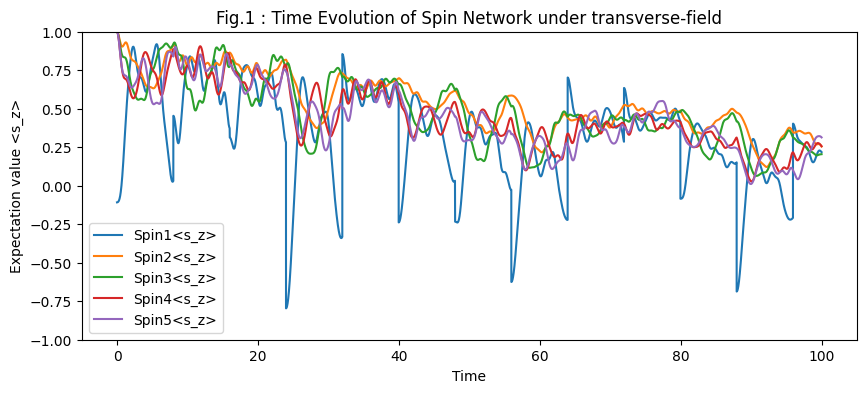

In [232]:
# Plot the result for time-evolved observables
plt.figure(figsize = (10,4))
for j in range(Num_spins):
    plt.plot(tlist, expectation_values[5][j], label = f'Spin{j+1}<s_z>')

plt.ylim([-1, 1])
plt.xlabel('Time')
plt.ylabel('Expectation value <s_z>')
plt.title('Fig.1 : Time Evolution of Spin Network under transverse-field')
plt.legend()
plt.show()

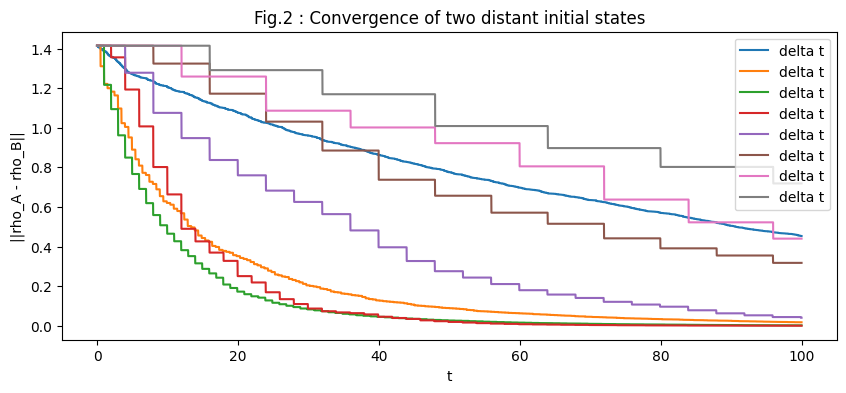

In [231]:
# Plot the result for time-evolved distance between two quantum states
plt.figure(figsize = (10,4))

for j in range(Num_trials):
    plt.plot(tlist, distance_values[j], label = f'delta t')

plt.xlabel('t')
plt.ylabel('||rho_A - rho_B||')
plt.title('Fig.2 : Convergence of two distant initial states')
plt.legend()
plt.show()

In [132]:
psi_current = tensor([basis(2, 0) for _ in range(Num_spins)])                # Define the initial state 1 and state 2 (for testing fading memory)
psi_current_1 = tensor([basis(2, 1) for _ in range(Num_spins)])
rho_current = psi_current * psi_current.dag()
rho_current_1 = psi_current_1 * psi_current_1.dag()

diff = rho_current - rho_current_1
distance = np.sqrt((diff.dag() * diff).tr())

distance



1.4142135623730951

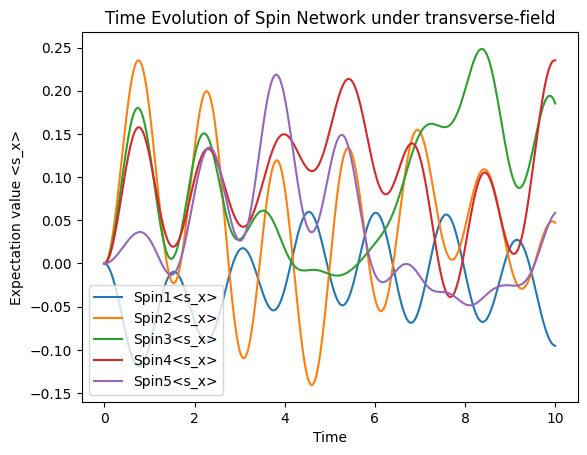

In [101]:
# Define initial state
psi_current = tensor([basis(2, 0) for _ in range(Num_spins)])
rho_current = psi_current * psi_current.dag()


# Evolve the system
result = mesolve(H, psi_current, tlist, [], [tensor([sx if i==j else si for i in range(Num_spins)]) for j in range(Num_spins)])

# Plot the result
for j in range(Num_spins):
    plt.plot(tlist, result.expect[j], label = f'Spin{j+1}<s_x>')

plt.xlabel('Time')
plt.ylabel('Expectation value <s_x>')
plt.title('Time Evolution of Spin Network under transverse-field')
plt.legend()
plt.show()